In [60]:
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(2)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(24)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(26)

# 5. Configure a new global `tensorflow` session
#from keras import backend as K

from tensorflow.python.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting

from sklearn import preprocessing  #用來標準化刻度
from keras.models import Sequential
from keras.layers import Dense,Dropout  
from sklearn.model_selection import train_test_split
from keras.losses import logcosh, categorical_crossentropy
from keras.utils import to_categorical
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
# Import Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

####################################################################################  x_lstm_validation

T=21

train_cardiac_total=pd.read_csv("mimic_dead_vital_sign_combine_train_"+str(T)+"hours.csv")
test_cardiac_total=pd.read_csv("mimic_dead_vital_sign_combine_test_"+str(T)+"hours.csv")
train_cardiac_base_total=pd.read_csv("mimic_dead_baseline_total_v2.csv")

total_train=24100 #control+event
total_test=6025 #control+event
train_control=21160 #control

var=76
random=32
smote_ratio=1
near_ratio=1
EPOCH = 3                    # number of epochs
BATCH = 32                      # batch size

dropout=0.4
LR = 0.001                           # learning rate of the gradient descent
LAMBD = 0.001                       # lambda in L2 regularizaion

#####################################################################################
train_cardiac_total=train_cardiac_total.drop(['subject_id'],axis=1)
train_cardiac_total=train_cardiac_total.drop(['stay_id'],axis=1)
train_cardiac_total=train_cardiac_total.drop(['indextime'],axis=1)
train_cardiac_total=train_cardiac_total.drop(['date'],axis=1)
train_cardiac_total=train_cardiac_total.drop(['hours_diff'],axis=1)
train_cardiac_total=train_cardiac_total.drop(['event'],axis=1)

test_cardiac_total=test_cardiac_total.drop(['subject_id'],axis=1)
test_cardiac_total=test_cardiac_total.drop(['stay_id'],axis=1)
test_cardiac_total=test_cardiac_total.drop(['indextime'],axis=1)
test_cardiac_total=test_cardiac_total.drop(['date'],axis=1)
test_cardiac_total=test_cardiac_total.drop(['hours_diff'],axis=1)
test_cardiac_total=test_cardiac_total.drop(['event'],axis=1)

#train_cardiac_total=train_cardiac_total.drop(['hadm_id'],axis=1)
#train_cardiac_total=train_cardiac_total.drop(['stay_id'],axis=1)
#train_cardiac_total=train_cardiac_total.drop(['los'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['CA'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['hospDIED'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['cardR'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['DNR'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['CMO'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['DNRDNI'],axis=1)

#train_cardiac_base_total=train_cardiac_base_total.drop(['DNI'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['FullCode'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['indextime'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['ccs9'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['ccs10'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['cardRv2'],axis=1)

###############CXR##############
#train_cardiac_base_total=train_cardiac_base_total.drop(['Atelectasis'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Cardiomegaly'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Consolidation'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Edema'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Enlarged Cardiomediastinum'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Fracture'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Lung Lesion'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Lung Opacity'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['No Finding'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pleural Effusion'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pleural Other'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pneumonia'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pneumothorax'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Support Devices'],axis=1)
###############CXR##############

#train_cardiac_base_total=pd.get_dummies(data=train_cardiac_base_total,columns=["first_careunit","ethnicity","BMI"])
train_cardiac_total=pd.get_dummies(data=train_cardiac_total,columns=["first_careunit","ethnicity"])
test_cardiac_total=pd.get_dummies(data=test_cardiac_total,columns=["first_careunit","ethnicity"])

train_cardiac_total11=train_cardiac_total

####################################################################
df_train_base=train_cardiac_base_total[:total_train]
y_train=df_train_base[['eventV3']].values   #取train_labels
df_test_base=train_cardiac_base_total[total_train:]
y_test=df_test_base[['eventV3']].values   #取test_labels

#x_train_base=train_features
#x_test_base=test_features

sm = SMOTE(random_state=random, sampling_strategy=smote_ratio)
nr = NearMiss(sampling_strategy=near_ratio) 

#x_train_base, y_train_base = sm.fit_sample(x_train_base, y_train_base.ravel())
#x_train_base, y_train_base = nr.fit_sample(x_train_base, y_train_base.ravel())

#train_cardiac_total=train_cardiac_total.drop(['eventV3'],axis=1)

train_cardiac_total=train_cardiac_total.values  
train_cardiac_total=np.array(train_cardiac_total).reshape(total_train,T*var) #轉二維  array
train_cardiac_total= pd.DataFrame(train_cardiac_total)

x_test_lstm=test_cardiac_total.values 
#x_test_lstm=minmax_scale.fit_transform(x_test_lstm)  #規一化
x_test_lstm=np.array(x_test_lstm).reshape(total_test,T,var) 

x_train_lstm, y_train = sm.fit_sample(train_cardiac_total, y_train.ravel())

#x_train_lstm=minmax_scale.fit_transform(x_train_lstm)  #規一化

x_train_lstm=np.array(x_train_lstm).reshape(x_train_lstm.shape[0],T,var) #轉三維  total

#x_train_lstm_nr=np.array(x_train_lstm_nr).reshape(x_train_lstm_nr.shape[0],T,var) #轉三維  total

#x_train_lstm_no_smote=np.array(train_cardiac_total).reshape(train_cardiac_total.shape[0],T,var) #轉三維  total

print('timeline:',train_cardiac_total.shape)
print('timeline:',x_train_lstm.shape)
print('label:',y_train.shape)

#print('timeline:',test_cardiac_total.shape)
print('timeline:',x_test_lstm.shape)
print('label:',y_test.shape)

#print('timeline_no_smote:',x_train_lstm_no_smote.shape)
#print('label_no_smote:',y_train_no_smote.shape)

#print('timeline_nr:',x_train_lstm_nr.shape)
#print('label_nr:',y_train_nr.shape)
#print(df_train_base.columns)


timeline: (24100, 1596)
timeline: (42320, 21, 76)
label: (42320,)
timeline: (6025, 21, 76)
label: (6025, 1)


In [61]:
print(x_train_lstm.shape)
print(y_train.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm.shape[0]           # number of training examples (2D)
#M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_smote = Sequential()

model_smote.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_smote.add(Dropout(dropout))
model_smote.add(BatchNormalization())


model_smote.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_smote.add(Dropout(dropout))
model_smote.add(BatchNormalization())

model_smote.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_smote.add(Dropout(dropout))
model_smote.add(BatchNormalization())


model_smote.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_smote.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_smote.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_smote.fit(x_train_lstm, y_train,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.2,
                    #validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_smote.evaluate(x_train_lstm, y_train,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_smote.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

(42320, 21, 76)
(42320,)
layers=[8, 8, 8, 1], train_examples=42320, test_examples=6025
batch = 32, timesteps = 21, features = 76, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 21, 8)             2720      
_________________________________________________________________
dropout_37 (Dropout)         (None, 21, 8)             0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 21, 8)             32        
_________________________________________________________________
lstm_38 (LSTM)               (None, 21, 8)             544       
_________________________________________________________________
dropout_38 (Dropout)         (None, 21, 8)             0         
__________________________________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 138s - loss: 0.3834 - accuracy: 0.8475 - f1_m: 0.7841 - precision_m: 0.8222 - val_loss: 1.2777 - val_accuracy: 0.1512 - val_f1_m: 0.2583 - val_precision_m: 1.0000
Epoch 3/3
 - 79s - loss: 0.3620 - accuracy: 0.8527 - f1_m: 0.7923 - precision_m: 0.8301 - val_loss: 0.8145 - val_accuracy: 0.4592 - val_f1_m: 0.6248 - val_precision_m: 1.0000
-----------------------------------------------------------------
Training was completed in 400.43 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 72.6229%
test accuracy = 92.9461%
test error = 425 out of 6025 examples


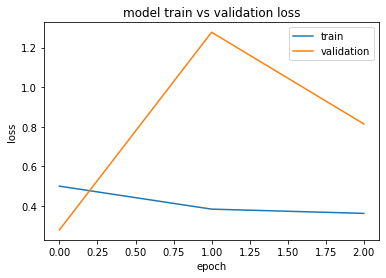

In [62]:
from matplotlib import pyplot 

pyplot.plot(History.history['loss']) 
pyplot.plot(History.history['val_loss']) 
pyplot.title('model train vs validation loss') 
pyplot.ylabel('loss') 
pyplot.xlabel('epoch') 
pyplot.legend(['train','validation'],loc='upper right') 
pyplot.show() 


In [63]:
y_pred_smote= model_smote.predict(x_test_lstm)

predict_test_smote=[]
for i in range(y_pred_smote.shape[0]): 
    if y_pred_smote[i]>0.5:
        predict_test_smote.append(1)
    else:
        predict_test_smote.append(0)
predict_test_smote = np.array(predict_test_smote)
print(predict_test_smote)

[0 0 0 ... 0 0 0]


In [64]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_smote,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_smote)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
accuracy= (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0])   #FPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('accuracy:',accuracy)
print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[5241   48]
 [ 377  359]]
accuracy: 0.9294605809128631
specificity: 0.9909245604083948
sensitivity: 0.48777173913043476
ppv: 0.8820638820638821
npv: 0.9328942684229263


<Figure size 432x288 with 0 Axes>

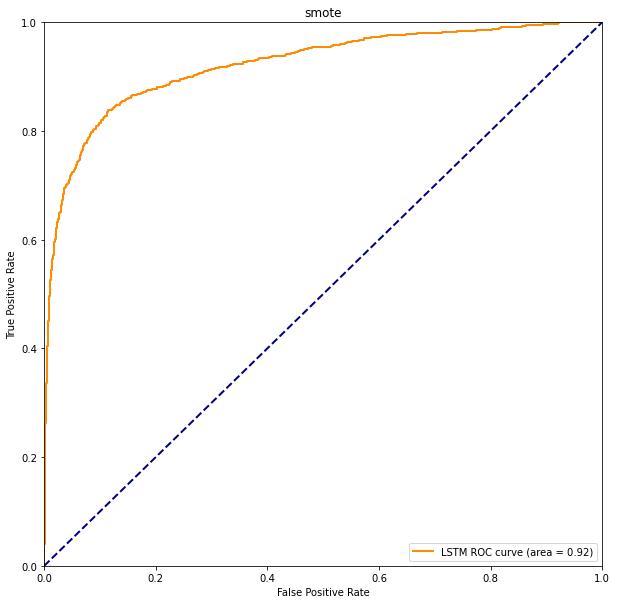

In [65]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_pred_smote) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('smote')
plt.legend(loc="lower right")

plt.show()

In [66]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo1
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[part_0:], x_event_1[part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[:part_0], x_event_1[:part_1]))

y_train_lstm_new=np.concatenate((y_event_0[part_0:], y_event_1[part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[:part_0], y_event_1[:part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_1 = Sequential()

model_1.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())


model_1.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())

model_1.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())


model_1.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_1.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_1.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History_1 = model_1.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_1.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_1.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred1= model_1.predict(x_test_lstm)
predict_train_lstm1=model_1.predict(x_train_lstm)

test_acc_1=test_acc
test_precision_1=test_precision


(33856, 21, 76)
(8464, 21, 76)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=6025
batch = 32, timesteps = 21, features = 76, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 21, 8)             2720      
_________________________________________________________________
dropout_40 (Dropout)         (None, 21, 8)             0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 21, 8)             32        
_________________________________________________________________
lstm_41 (LSTM)               (None, 21, 8)             544       
_________________________________________________________________
dropout_41 (Dropout)         (None, 21, 8)             0         
___________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 95s - loss: 0.7033 - accuracy: 0.5010 - f1_m: 0.4994 - precision_m: 0.5009 - val_loss: 0.6982 - val_accuracy: 0.5002 - val_f1_m: 4.5740e-04 - val_precision_m: 0.0075
Epoch 3/3
 - 96s - loss: 0.6976 - accuracy: 0.4993 - f1_m: 0.4829 - precision_m: 0.4989 - val_loss: 0.6954 - val_accuracy: 0.4994 - val_f1_m: 0.5010 - val_precision_m: 0.5009
-----------------------------------------------------------------
Training was completed in 409.83 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 49.9911%
test accuracy = 12.1494%
test error = 5293 out of 6025 examples


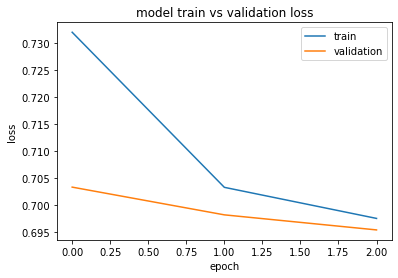

In [92]:
from matplotlib import pyplot 

pyplot.plot(History_1.history['loss']) 
pyplot.plot(History_1.history['val_loss']) 
pyplot.title('model train vs validation loss') 
pyplot.ylabel('loss') 
pyplot.xlabel('epoch') 
pyplot.legend(['train','validation'],loc='upper right') 
pyplot.show() 


In [93]:
predict_test_1=[]
for i in range(y_pred1.shape[0]): 
    if y_pred1[i]>0.5:
        predict_test_1.append(1)
    else:
        predict_test_1.append(0)
predict_test_1 = np.array(predict_test_1)
print(predict_test_1)

[1 1 1 ... 1 1 1]


In [95]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_1,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_1)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

accuracy= (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0])   #FPR
print('accuracy:',accuracy)

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[   0 5289]
 [   4  732]]
accuracy: 0.12149377593360997
specificity: 0.0
sensitivity: 0.9945652173913043
ppv: 0.12157448928749377
npv: 0.0


In [70]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo2
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:part_0], x_event_1[:part_1],x_event_0[2*part_0:],x_event_1[2*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[part_0:2*part_0], x_event_1[part_1:2*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:part_0], y_event_1[:part_1],y_event_0[2*part_0:], y_event_1[2*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[part_0:2*part_0], y_event_1[part_1:2*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)


LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_2 = Sequential()

model_2.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_2.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_2.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History_2 = model_2.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_2.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_2.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred2= model_2.predict(x_test_lstm)
predict_train_lstm2=model_2.predict(x_train_lstm)

test_acc_2=test_acc
test_precision_2=test_precision


(33856, 21, 76)
(8464, 21, 76)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=6025
batch = 32, timesteps = 21, features = 76, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 21, 8)             2720      
_________________________________________________________________
dropout_43 (Dropout)         (None, 21, 8)             0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 21, 8)             32        
_________________________________________________________________
lstm_44 (LSTM)               (None, 21, 8)             544       
_________________________________________________________________
dropout_44 (Dropout)         (None, 21, 8)             0         
___________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 78s - loss: 0.4398 - accuracy: 0.8294 - f1_m: 0.8191 - precision_m: 0.8578 - val_loss: 0.3773 - val_accuracy: 0.8427 - val_f1_m: 0.4791 - val_precision_m: 0.5017
Epoch 3/3
 - 123s - loss: 0.3913 - accuracy: 0.8483 - f1_m: 0.8459 - precision_m: 0.8487 - val_loss: 0.4197 - val_accuracy: 0.8177 - val_f1_m: 0.4948 - val_precision_m: 0.5017
-----------------------------------------------------------------
Training was completed in 387.37 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 81.8496%
test accuracy = 69.7925%
test error = 1820 out of 6025 examples


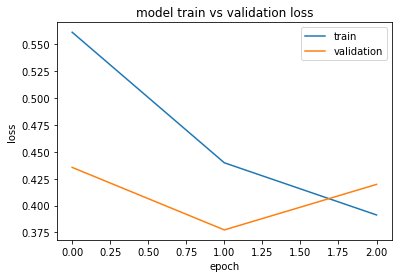

In [71]:
from matplotlib import pyplot 

pyplot.plot(History_2.history['loss']) 
pyplot.plot(History_2.history['val_loss']) 
pyplot.title('model train vs validation loss') 
pyplot.ylabel('loss') 
pyplot.xlabel('epoch') 
pyplot.legend(['train','validation'],loc='upper right') 
pyplot.show() 


In [72]:
predict_test_2=[]
for i in range(y_pred2.shape[0]): 
    if y_pred2[i]>0.5:
        predict_test_2.append(1)
    else:
        predict_test_2.append(0)
predict_test_2 = np.array(predict_test_2)
print(predict_test_2)

[0 0 0 ... 1 0 1]


In [96]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_2,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_2)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])   

accuracy= (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0])   #FPR
print('accuracy:',accuracy)

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[3528 1761]
 [  59  677]]
accuracy: 0.6979253112033195
specificity: 0.6670448099829835
sensitivity: 0.9198369565217391
ppv: 0.2776866283839213
npv: 0.9835517145246724


In [74]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo3
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:2*part_0], x_event_1[:2*part_1],x_event_0[3*part_0:],x_event_1[3*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[2*part_0:3*part_0], x_event_1[2*part_1:3*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:2*part_0], y_event_1[:2*part_1],y_event_0[3*part_0:], y_event_1[3*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[2*part_0:3*part_0], y_event_1[2*part_1:3*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_3 = Sequential()

model_3.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_3.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_3.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History_3 = model_3.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_3.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_3.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred3= model_3.predict(x_test_lstm)
predict_train_lstm3=model_3.predict(x_train_lstm)

test_acc_3=test_acc
test_precision_3=test_precision

(33856, 21, 76)
(8464, 21, 76)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=6025
batch = 32, timesteps = 21, features = 76, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 21, 8)             2720      
_________________________________________________________________
dropout_46 (Dropout)         (None, 21, 8)             0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 21, 8)             32        
_________________________________________________________________
lstm_47 (LSTM)               (None, 21, 8)             544       
_________________________________________________________________
dropout_47 (Dropout)         (None, 21, 8)             0         
___________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 131s - loss: 0.4701 - accuracy: 0.8015 - f1_m: 0.7878 - precision_m: 0.8393 - val_loss: 0.4420 - val_accuracy: 0.8097 - val_f1_m: 0.4017 - val_precision_m: 0.5017
Epoch 3/3
 - 125s - loss: 0.4282 - accuracy: 0.8233 - f1_m: 0.8164 - precision_m: 0.8410 - val_loss: 0.4294 - val_accuracy: 0.8145 - val_f1_m: 0.4229 - val_precision_m: 0.5017
-----------------------------------------------------------------
Training was completed in 409.46 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 80.9103%
test accuracy = 87.9502%
test error = 726 out of 6025 examples


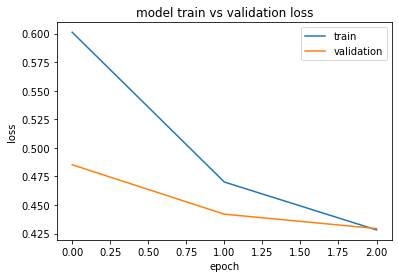

In [75]:
from matplotlib import pyplot 

pyplot.plot(History_3.history['loss']) 
pyplot.plot(History_3.history['val_loss']) 
pyplot.title('model train vs validation loss') 
pyplot.ylabel('loss') 
pyplot.xlabel('epoch') 
pyplot.legend(['train','validation'],loc='upper right') 
pyplot.show() 


In [76]:
predict_test_3=[]
for i in range(y_pred3.shape[0]): 
    if y_pred3[i]>0.5:
        predict_test_3.append(1)
    else:
        predict_test_3.append(0)
predict_test_3 = np.array(predict_test_3)
print(predict_test_3)

[0 0 0 ... 1 0 0]


In [97]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_3,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_3)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

accuracy= (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0])   #FPR
print('accuracy:',accuracy)

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[4738  551]
 [ 175  561]]
accuracy: 0.8795020746887967
specificity: 0.8958215163546984
sensitivity: 0.7622282608695652
ppv: 0.5044964028776978
npv: 0.9643802157541217


In [78]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo4
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:3*part_0], x_event_1[:3*part_1],x_event_0[4*part_0:],x_event_1[4*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[3*part_0:4*part_0], x_event_1[3*part_1:4*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:3*part_0], y_event_1[:3*part_1],y_event_0[4*part_0:], y_event_1[4*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[3*part_0:4*part_0], y_event_1[3*part_1:4*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)


LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_4 = Sequential()

model_4.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
           #    dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_4.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_4.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History_4 = model_4.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_4.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_4.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred4= model_4.predict(x_test_lstm)
predict_train_lstm4=model_4.predict(x_train_lstm)

test_acc_4=test_acc
test_precision_4=test_precision


(33856, 21, 76)
(8464, 21, 76)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=6025
batch = 32, timesteps = 21, features = 76, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 21, 8)             2720      
_________________________________________________________________
dropout_49 (Dropout)         (None, 21, 8)             0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 21, 8)             32        
_________________________________________________________________
lstm_50 (LSTM)               (None, 21, 8)             544       
_________________________________________________________________
dropout_50 (Dropout)         (None, 21, 8)             0         
___________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 69s - loss: 0.4338 - accuracy: 0.8298 - f1_m: 0.8265 - precision_m: 0.8327 - val_loss: 0.9505 - val_accuracy: 0.5084 - val_f1_m: 0.5012 - val_precision_m: 0.5009
Epoch 3/3
 - 68s - loss: 0.3846 - accuracy: 0.8522 - f1_m: 0.8505 - precision_m: 0.8488 - val_loss: 1.3345 - val_accuracy: 0.5000 - val_f1_m: 0.5013 - val_precision_m: 0.5009
-----------------------------------------------------------------
Training was completed in 220.16 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 50.0%
test accuracy = 12.2158%
test error = 5289 out of 6025 examples


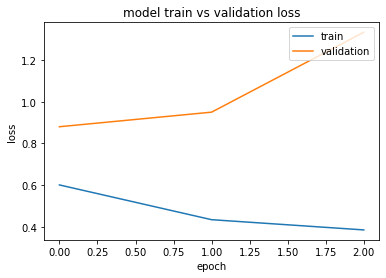

In [79]:
from matplotlib import pyplot 

pyplot.plot(History_4.history['loss']) 
pyplot.plot(History_4.history['val_loss']) 
pyplot.title('model train vs validation loss') 
pyplot.ylabel('loss') 
pyplot.xlabel('epoch') 
pyplot.legend(['train','validation'],loc='upper right') 
pyplot.show() 


In [80]:
predict_test_4=[]
for i in range(y_pred4.shape[0]): 
    if y_pred4[i]>0.5:
        predict_test_4.append(1)
    else:
        predict_test_4.append(0)
predict_test_4 = np.array(predict_test_4)
print(predict_test_4)

[1 1 1 ... 1 1 1]


In [98]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_4,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_4)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0]) 

accuracy= (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0])   #FPR
print('accuracy:',accuracy)

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[   0 5289]
 [   0  736]]
accuracy: 0.12215767634854771
specificity: 0.0
sensitivity: 1.0
ppv: 0.12215767634854771
npv: nan


C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  from ipykernel import kernelapp as app


In [82]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo5
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:4*part_0], x_event_1[:4*part_1]))
x_valid_lstm_new=np.concatenate((x_event_0[4*part_0:], x_event_1[4*part_1:]))

y_train_lstm_new=np.concatenate((y_event_0[:4*part_0], y_event_1[:4*part_1]))
y_valid_lstm_new=np.concatenate((y_event_0[4*part_0:], y_event_1[4*part_1:]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_5 = Sequential()

model_5.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
           #    dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_5.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_5.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History_5 = model_5.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_5.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_5.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred5= model_5.predict(x_test_lstm)
predict_train_lstm5=model_5.predict(x_train_lstm)

test_acc_5=test_acc
test_precision_5=test_precision

(33856, 21, 76)
(8464, 21, 76)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=6025
batch = 32, timesteps = 21, features = 76, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 21, 8)             2720      
_________________________________________________________________
dropout_52 (Dropout)         (None, 21, 8)             0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 21, 8)             32        
_________________________________________________________________
lstm_53 (LSTM)               (None, 21, 8)             544       
_________________________________________________________________
dropout_53 (Dropout)         (None, 21, 8)             0         
___________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 34s - loss: 0.4681 - accuracy: 0.8149 - f1_m: 0.8013 - precision_m: 0.8540 - val_loss: 0.4204 - val_accuracy: 0.8511 - val_f1_m: 0.4517 - val_precision_m: 0.5016
Epoch 3/3
 - 33s - loss: 0.4134 - accuracy: 0.8431 - f1_m: 0.8360 - precision_m: 0.8590 - val_loss: 0.5292 - val_accuracy: 0.7398 - val_f1_m: 0.4951 - val_precision_m: 0.5013
-----------------------------------------------------------------
Training was completed in 117.49 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 73.6886%
test accuracy = 54.7718%
test error = 2725 out of 6025 examples


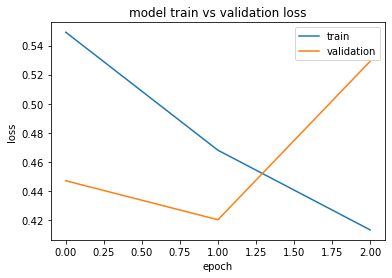

In [83]:
from matplotlib import pyplot 

pyplot.plot(History_5.history['loss']) 
pyplot.plot(History_5.history['val_loss']) 
pyplot.title('model train vs validation loss') 
pyplot.ylabel('loss') 
pyplot.xlabel('epoch') 
pyplot.legend(['train','validation'],loc='upper right') 
pyplot.show() 


In [84]:
predict_test_5=[]
for i in range(y_pred5.shape[0]): 
    if y_pred5[i]>0.5:
        predict_test_5.append(1)
    else:
        predict_test_5.append(0)
predict_test_5 = np.array(predict_test_5)
print(predict_test_5)

[1 0 0 ... 1 1 1]


In [99]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_5,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_5)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

accuracy= (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0])   #FPR
print('accuracy:',accuracy)

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[2611 2678]
 [  47  689]]
accuracy: 0.5477178423236515
specificity: 0.4936660994516922
sensitivity: 0.936141304347826
ppv: 0.20463320463320464
npv: 0.9823175319789316


In [100]:
y_pred_temp=np.append(y_pred1,y_pred2)
y_pred_temp=np.append(y_pred_temp,y_pred3)
y_pred_temp=np.append(y_pred_temp,y_pred4)
y_pred_temp=np.append(y_pred_temp,y_pred5)

predict_train_temp=np.append(predict_train_lstm1,predict_train_lstm2)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm3)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm4)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm5)

y_pred=np.array(y_pred_temp).reshape(x_test_lstm.shape[0],5, order='F') #轉維
predict_train_lstm=np.array(predict_train_temp).reshape(x_train_lstm.shape[0],5, order='F') #轉維

y_pred= np.mean(y_pred, axis=1)
predict_train_lstm= np.mean(predict_train_lstm, axis=1)
 

In [87]:
predict_test=[]
for i in range(y_pred.shape[0]): 
    if y_pred[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)
print(predict_test)

[1 0 0 ... 1 1 1]


In [101]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

accuracy_5_fold=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])

specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[0,1])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


y_pred=np.array(y_pred).reshape(total_test)

flag=0
total_predict=0
for i in range(y_pred.shape[0]): 
      if y_pred[i]>0.5:
            total_predict=total_predict+y_pred[i]
            flag=flag+1
            

Confusion Matrix : 
 [[2731 2558]
 [  37  699]]
specificity: 0.5163546984307053
sensitivity: 0.9497282608695652
ppv: 0.21461467608228432
npv: 0.5163546984307053


<Figure size 432x288 with 0 Axes>

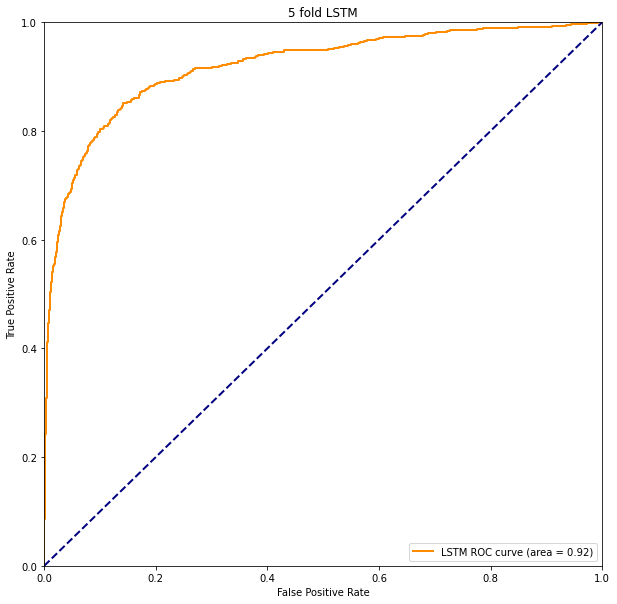

In [102]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('5 fold LSTM')
plt.legend(loc="lower right")

plt.show()

In [103]:
print('accuracy : %0.2f' %accuracy_5_fold)  #accuracy
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)
#print('f1_score :%0.2f' %test_f1_score)  #f1_score
print(total_predict/flag*100)  #score

accuracy : 0.57
AUC : 0.92
Sensitivity : 0.95
Specificity :0.52
65.49953547291204


In [91]:
y_pred

array([0.51681125, 0.47642344, 0.423769  , ..., 0.7334065 , 0.5629419 ,
       0.6263844 ], dtype=float32)